In [1]:
library(tidyverse)
library(wesanderson)
library(ggridges)
library(ggthemes)
library(reshape)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 2.2.1     ✔ purrr   0.2.4
✔ tibble  1.4.2     ✔ dplyr   0.7.4
✔ tidyr   0.8.0     ✔ stringr 1.2.0
✔ readr   1.1.1     ✔ forcats 0.2.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘reshape’

The following object is masked from ‘package:dplyr’:

    rename

The following objects are masked from ‘package:tidyr’:

    expand, smiths



In [2]:
# agg_data_path = '~./volatileValues/simple_rt_experiment_probabilityC/analysis/aggregated_data/'
# setwd(agg_data_path)

In [3]:
linux_data_path <- '/home/krista/Documents/gitRepositories/volatileValues/simple_rt_experiment_probabilityC/data/'
setwd(linux_data_path)

In [4]:
(files <- dir(path = linux_data_path, pattern = "^[0-9](.*)(_trialset[0-9].csv)$"))

[1] "0761_cond0_trialset0.csv" "0761_cond1_trialset0.csv"
 [3] "0761_cond2_trialset0.csv" "0761_cond3_trialset0.csv"
 [5] "0762_cond0_trialset1.csv" "0762_cond1_trialset1.csv"
 [7] "0762_cond2_trialset1.csv" "0762_cond3_trialset1.csv"
 [9] "0763_cond0_trialset2.csv" "0763_cond1_trialset2.csv"
[11] "0763_cond2_trialset2.csv" "0763_cond3_trialset2.csv"
[13] "0764_cond0_trialset3.csv" "0764_cond1_trialset3.csv"
[15] "0764_cond2_trialset3.csv" "0764_cond3_trialset3.csv"
[17] "0765_cond0_trialset4.csv" "0765_cond1_trialset4.csv"
[19] "0765_cond2_trialset4.csv" "0765_cond3_trialset4.csv"
[21] "0766_cond0_trialset5.csv" "0766_cond1_trialset5.csv"
[23] "0766_cond2_trialset5.csv" "0766_cond3_trialset5.csv"

In [5]:
raw_df <- files %>%
  map(read_csv,col_types = cols()) %>%                  
  reduce(rbind) 

In [6]:
(ID = map(files, substr, start=1, stop=4))
raw_df$ID = as.numeric(ID)

[[1]]
[1] "0761"

[[2]]
[1] "0761"

[[3]]
[1] "0761"

[[4]]
[1] "0761"

[[5]]
[1] "0762"

[[6]]
[1] "0762"

[[7]]
[1] "0762"

[[8]]
[1] "0762"

[[9]]
[1] "0763"

[[10]]
[1] "0763"

[[11]]
[1] "0763"

[[12]]
[1] "0763"

[[13]]
[1] "0764"

[[14]]
[1] "0764"

[[15]]
[1] "0764"

[[16]]
[1] "0764"

[[17]]
[1] "0765"

[[18]]
[1] "0765"

[[19]]
[1] "0765"

[[20]]
[1] "0765"

[[21]]
[1] "0766"

[[22]]
[1] "0766"

[[23]]
[1] "0766"

[[24]]
[1] "0766"

In [24]:


# Recode values with named arguments
x <- sample(c("a", "b", "c"), 10, replace = TRUE)
recode(x, a = "Apple")

[1] "b"     "c"     "b"     "c"     "c"     "b"     "b"     "c"     "Apple"
[10] "c"

In [32]:
condition = map(files, substr, start=10, stop=10)
raw_df$condition <- as.numeric(condition)
raw_df$condition <- recode(raw_df$condition, '0' = 'lc', '1' = 'hc', '2'='hv','3'='lv')
head(raw_df)

choice,accuracy,solution,reward,cumulative_reward,rt,total_trial_time,iti,cp_with_slow_fast,obs_cp_with_slow_fast,high_val_cue,ID,condition
1,0,0,0,599,0.4336741,1.697924,0.2664002,0,0,112,761,lc
1,0,0,0,598,0.3079350,1.724732,0.4243499,0,0,112,761,hc
1,1,1,2,599,0.4682131,1.818176,0.3592922,0,0,112,761,hv
0,1,0,3,601,0.2827091,1.747946,0.4737810,0,0,112,761,lv
1,0,0,0,600,0.2736750,1.727565,0.4681007,0,1,111,762,lc
0,1,0,2,601,0.2374198,1.901646,0.6695086,0,1,112,762,hc


In [33]:
(n_subjects = length(unique(raw_df$ID)))
(n_conditions = length(unique(raw_df$condition)))
n_clean_trials = 600
(expected_rows = n_subjects*n_conditions*n_clean_trials)

[1] 6

[1] 4

[1] 14400

In [34]:
fast_slow_trial_freq <- raw_df %>% 
    group_by(ID, condition) %>%  summarize(n_fast_trials = sum(cp_with_slow_fast == -2), 
n_slow_trials = sum(cp_with_slow_fast == -1))

(unique_conds_per_s <- raw_df %>% 
    group_by(ID) %>% summarise(unique_conds_per_s=n_distinct(condition)) )

ID,unique_conds_per_s
761,4
762,4
763,4
764,4
765,4
766,4


In [35]:
(total_n_trials <- n_clean_trials + fast_slow_trial_freq$n_fast_trials + fast_slow_trial_freq$n_slow_trials
)
round(fast_slow_trial_freq$n_fast_trials/total_n_trials,4)
round(fast_slow_trial_freq$n_slow_trials/total_n_trials,4)

[1] 605 608 605 608 605 610 601 604 603 606 606 603 610 607 609 608 607 602 609
[20] 606 607 608 605 602

[1] 0.0017 0.0049 0.0083 0.0132 0.0033 0.0115 0.0017 0.0050 0.0050 0.0033
[11] 0.0066 0.0050 0.0082 0.0082 0.0066 0.0099 0.0099 0.0017 0.0082 0.0066
[21] 0.0082 0.0082 0.0033 0.0033

[1] 0.0066 0.0082 0.0000 0.0000 0.0050 0.0049 0.0000 0.0017 0.0000 0.0066
[11] 0.0033 0.0000 0.0082 0.0033 0.0082 0.0033 0.0016 0.0017 0.0066 0.0033
[21] 0.0033 0.0049 0.0050 0.0000

In [36]:
head(raw_df)
n_subjects = length(unique(raw_df$ID))
n_conditions = length(unique(raw_df$condition))
clean_df <- subset(raw_df, cp_with_slow_fast == 0 | cp_with_slow_fast == 1)
clean_df$trial <- rep(seq(1,600),n_subjects*n_conditions)
dim(clean_df)

choice,accuracy,solution,reward,cumulative_reward,rt,total_trial_time,iti,cp_with_slow_fast,obs_cp_with_slow_fast,high_val_cue,ID,condition
1,0,0,0,599,0.4336741,1.697924,0.2664002,0,0,112,761,lc
1,0,0,0,598,0.3079350,1.724732,0.4243499,0,0,112,761,hc
1,1,1,2,599,0.4682131,1.818176,0.3592922,0,0,112,761,hv
0,1,0,3,601,0.2827091,1.747946,0.4737810,0,0,112,761,lv
1,0,0,0,600,0.2736750,1.727565,0.4681007,0,1,111,762,lc
0,1,0,2,601,0.2374198,1.901646,0.6695086,0,1,112,762,hc


[1] 14400    14

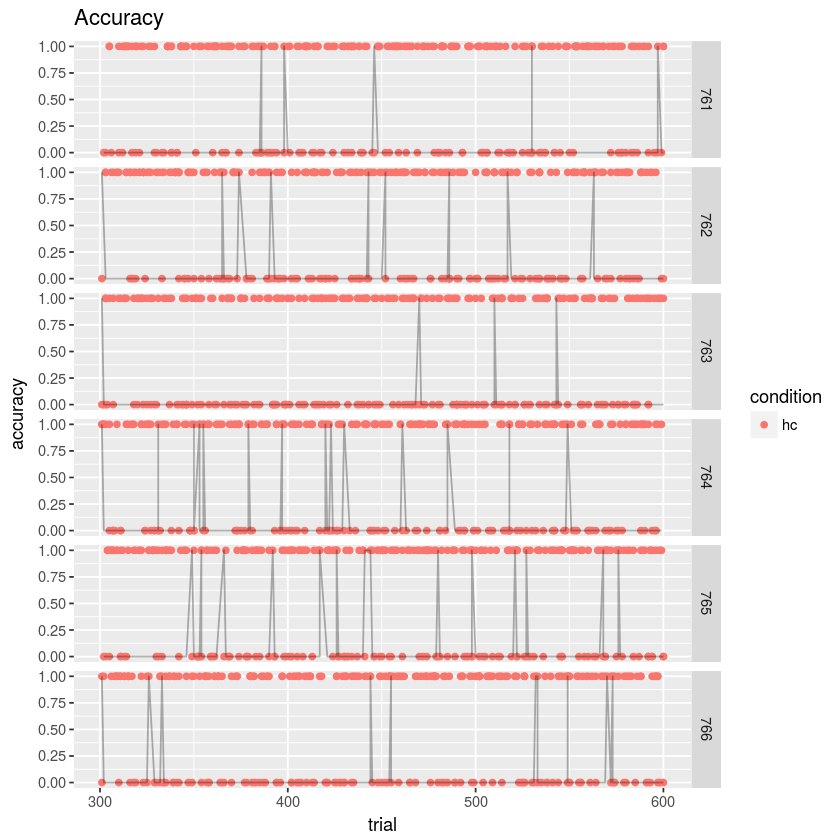

In [39]:
ggplot(subset(clean_df, condition=='hc' & trial > 300), aes(trial, accuracy, color=condition)) +
    geom_point() +  geom_line(data=subset(clean_df, condition=='hc'&  trial > 300), aes(trial, cp_with_slow_fast), alpha=0.3,col='black') + facet_grid( ID ~.) + ggtitle('Accuracy') 

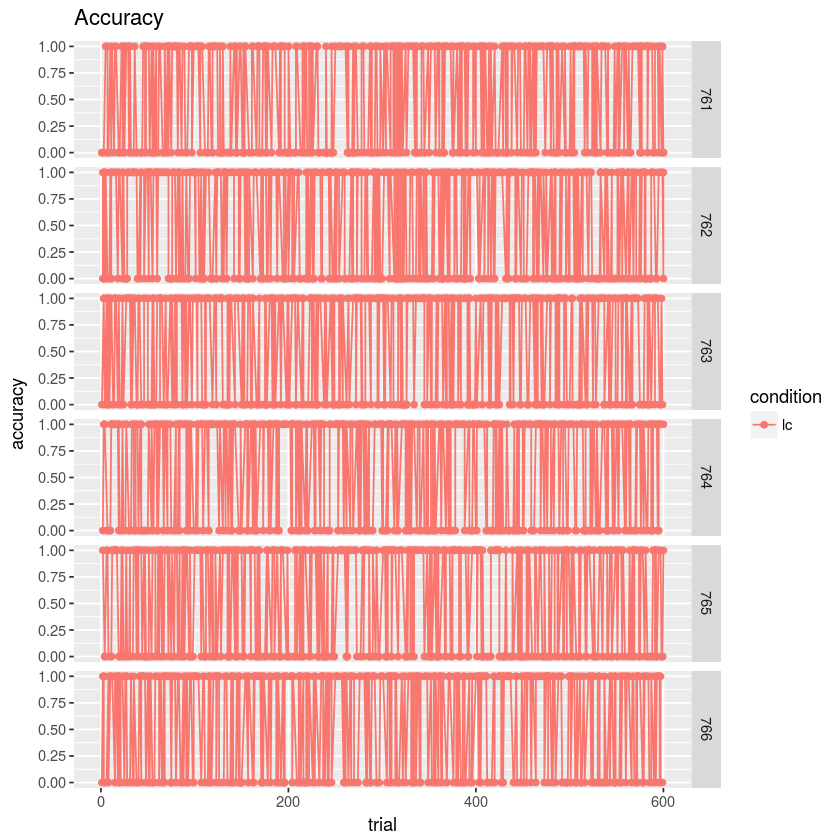

In [40]:
ggplot(subset(clean_df, condition=='lc'), aes(trial, accuracy, color=condition)) +
    geom_point() + geom_line() + facet_grid( ID~.) + ggtitle('Accuracy')

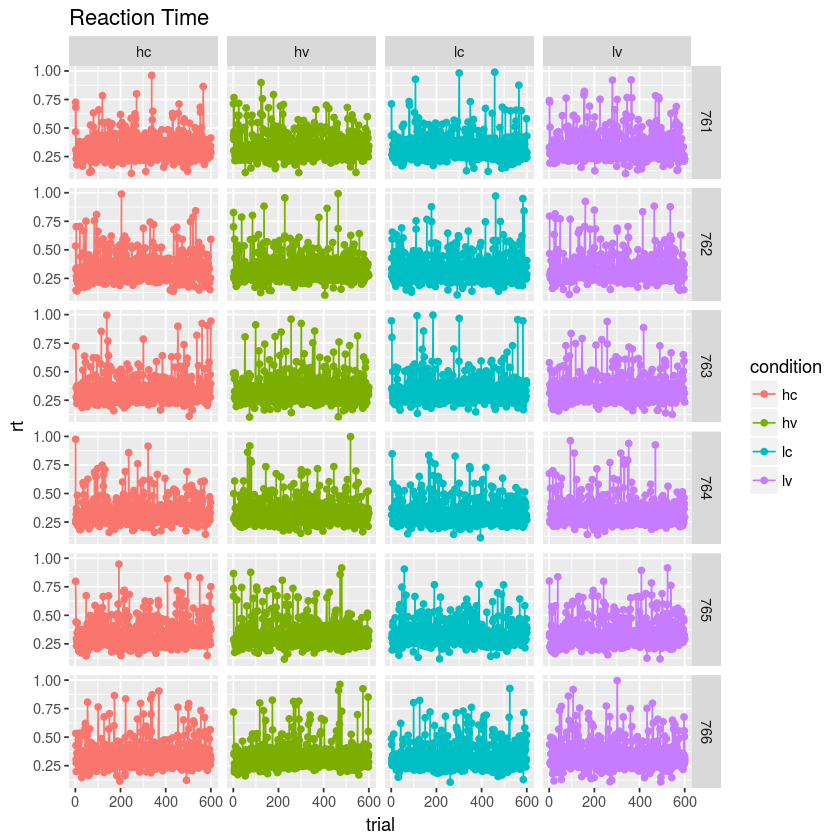

In [42]:
ggplot(clean_df, aes(trial, rt, color=condition)) +
    geom_point() + geom_line() + facet_grid(ID ~ condition) + ggtitle('Reaction Time')

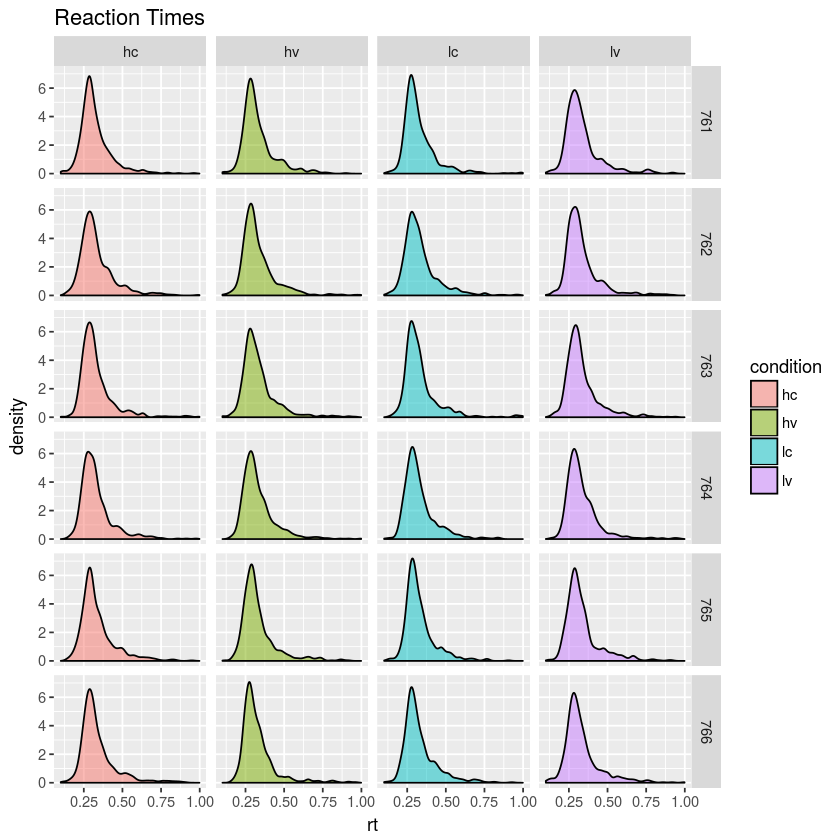

In [43]:
ggplot(clean_df, aes(rt, fill=condition)) +
geom_density(alpha=0.5) + facet_grid(ID ~ condition) + ggtitle('Reaction Times')

In [66]:
 clean_df %>% 
    group_by(condition) %>% summarize(mu_acc=mean(rt))

condition,mu_acc
hc,0.3319982
hv,0.3315500
lc,0.3302772
lv,0.3333962


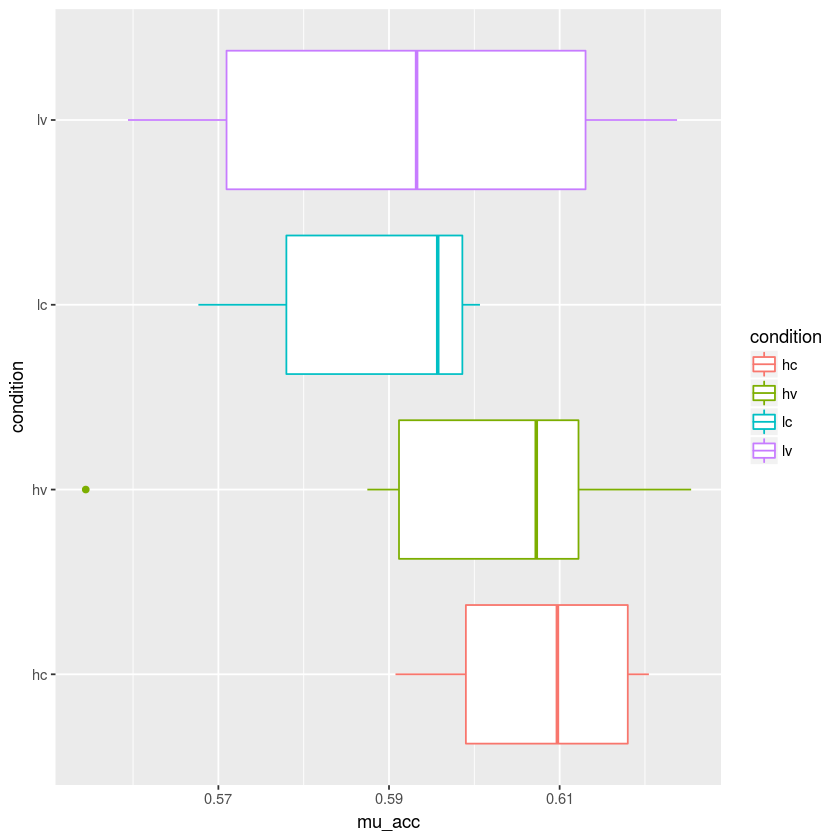

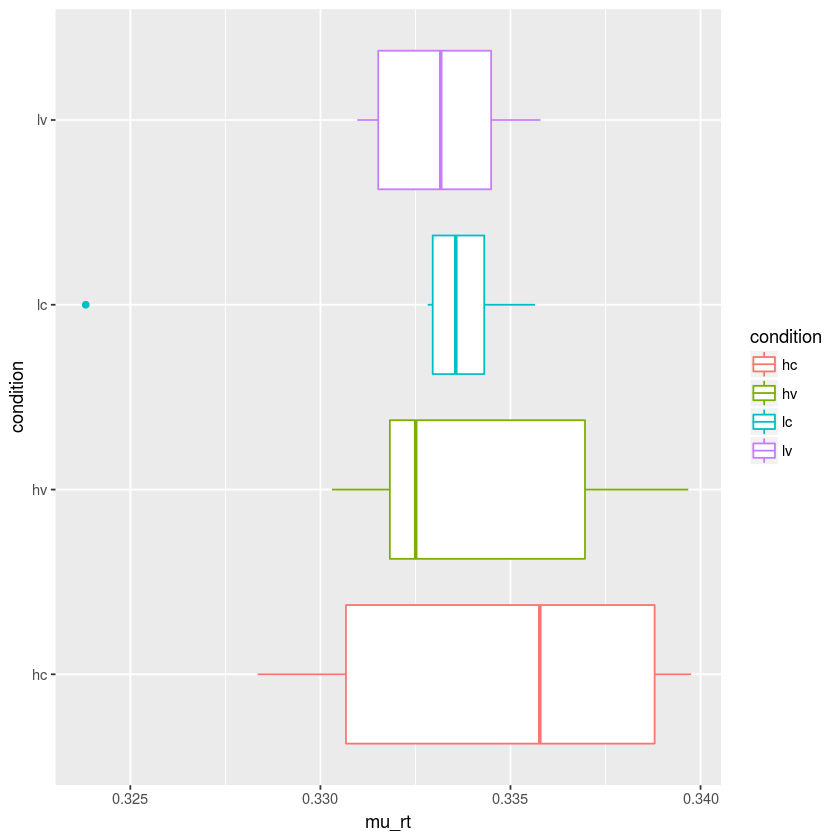

In [67]:
acc_stats <- raw_df %>% 
    group_by(ID, condition) %>% summarize(mu_acc=mean(accuracy))

rt_stats <- raw_df %>% 
    group_by(ID, condition) %>% summarize(mu_rt=mean(rt))

# ggplot(acc_stats, aes(mu_acc, ID)) +
#     geom_point(aes(fill=condition)) + coord_flip()

ggplot(acc_stats, aes(x=condition, y=mu_acc)) +
    geom_boxplot(aes(color=condition)) + coord_flip()

ggplot(rt_stats, aes(x=condition, y=mu_rt)) +
    geom_boxplot(aes(color=condition)) + coord_flip()

In [ ]:
ggplot(simulations, aes(rt,condition, fill=condition)) +
  geom_density_ridges(jittered_points = TRUE, position = "raincloud",
                      alpha = 0.7, aes(point_color = condition, point_fill = condition)) + facet_grid(condition ~.) + ggtitle('Simulated reaction time distributions ') 
# + theme_tufte()
# ggsave('s_rt_dist.pdf')

Picking joint bandwidth of 0.0126


Saving 6.67 x 6.67 in image
Picking joint bandwidth of 0.0126


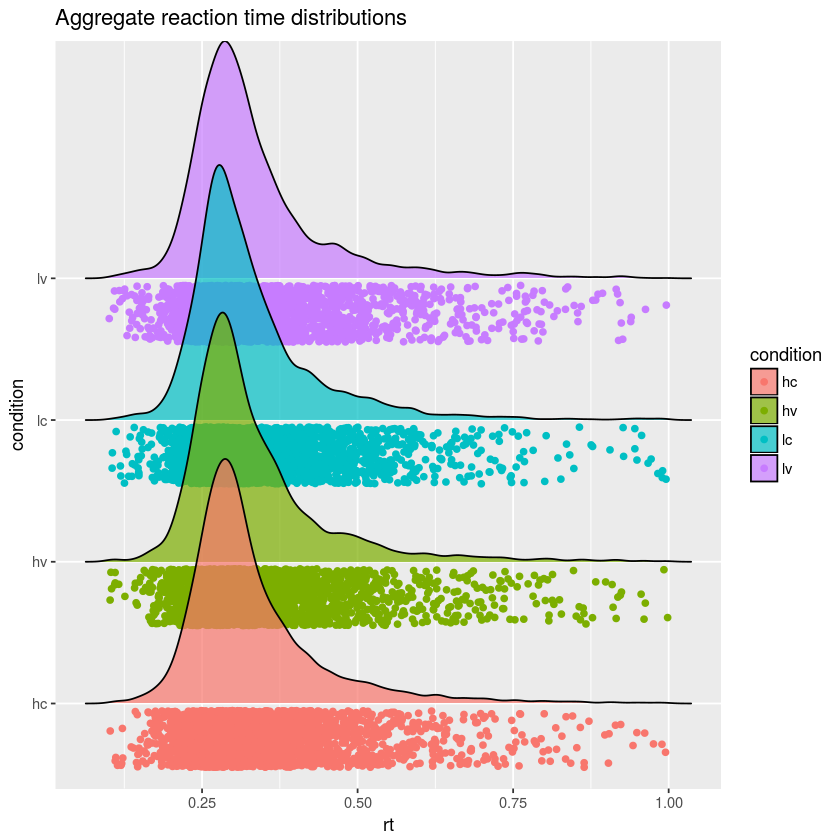

In [46]:
ggplot(clean_df, aes(rt,condition, fill=condition)) +
  geom_density_ridges(jittered_points = TRUE, position = "raincloud",
                      alpha = 0.7, aes(point_color = condition, point_fill = condition)) + ggtitle('Aggregate reaction time distributions ')

ggsave('condition_rt_dist.pdf')

Picking joint bandwidth of 0.123
Picking joint bandwidth of 0.123
Picking joint bandwidth of 0.123
Picking joint bandwidth of 0.123
Picking joint bandwidth of 0.123
Picking joint bandwidth of 0.122


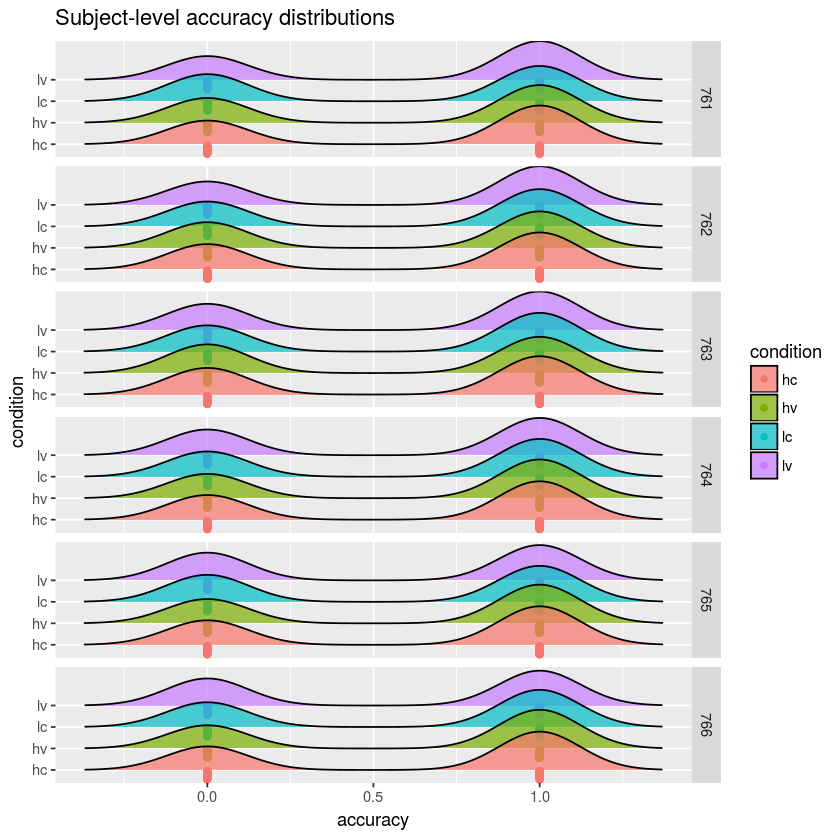

In [47]:
ggplot(clean_df, aes(accuracy,condition, fill=condition)) +
  geom_density_ridges(jittered_points = TRUE, position = "raincloud",
                      alpha = 0.7, aes(point_color = condition, point_fill = condition)) + facet_grid(ID ~.) + ggtitle('Subject-level accuracy distributions ')

Picking joint bandwidth of 0.0858


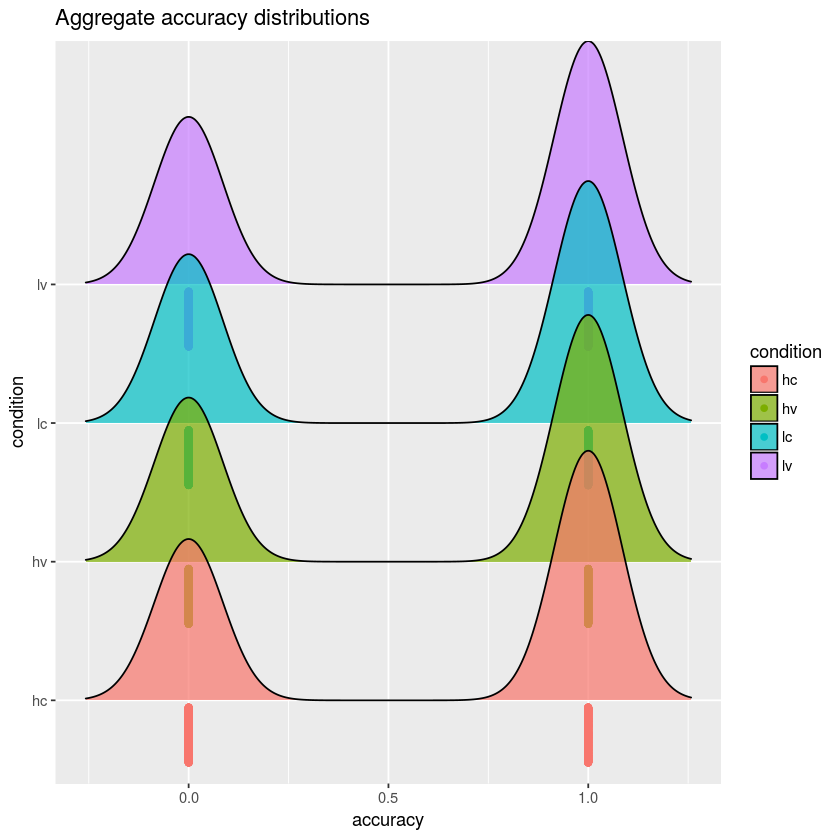

In [48]:
ggplot(clean_df, aes(accuracy,condition, fill=condition)) +
  geom_density_ridges(jittered_points = TRUE, position = "raincloud",
                      alpha = 0.7, aes(point_color = condition, point_fill = condition)) +  ggtitle('Aggregate accuracy distributions ')

In [49]:
#step 1: find the indices that correspond to the changepoint 
cp_idx <- which(clean_df$cp_with_slow_fast == 1)
#get trial before cp 
start_idx <- cp_idx - 1 
#add e. length  
end_idx <- cp_idx + 9

#construct intervals according to the start and end idx 
intervals <- mapply(seq, start_idx, end_idx)
conditions <- data.frame(condition=clean_df$condition[start_idx])
dim(conditions)

conditions_vec <- rep(conditions$condition, each=11)
rt_vec_slice <- clean_df$rt[intervals]
acc_vec_slice <- clean_df$accuracy[intervals]
# new_df = data.frame(t=conditions_vec)
# tail(new_df)

[1] 618   1

In [50]:
#check intervals
start_idx[3]
end_idx[3]
intervals[,3]
#next, construct new df with these vals. 

#interval columns are cps
#rows are trials

[1] 92

[1] 102

[1]  92  93  94  95  96  97  98  99 100 101 102

In [52]:
sliced_df <- melt(intervals)
colnames(sliced_df) <- c('epoch_trial', 'interval_number', 'trial')
head(sliced_df)
sliced_df$interval_number <- NULL 
str(sliced_df)


sliced_df$conditions <- conditions_vec
sliced_df$rt <- rt_vec_slice
sliced_df$acc <- acc_vec_slice

dim(sliced_df)
head(sliced_df)

epoch_trial,interval_number,trial
1,1,36
2,1,37
3,1,38
4,1,39
5,1,40
6,1,41


'data.frame':	6798 obs. of  2 variables:
 $ epoch_trial: int  1 2 3 4 5 6 7 8 9 10 ...
 $ trial      : int  36 37 38 39 40 41 42 43 44 45 ...


[1] 6798    5

epoch_trial,trial,conditions,rt,acc
1,36,lv,0.3102620,1
2,37,lv,0.2482722,0
3,38,lv,0.2787440,0
4,39,lv,0.3457289,1
5,40,lv,0.2704589,1
6,41,lv,0.2818220,1


In [53]:
lc <- sliced_df %>%
          filter(conditions =='lc')  

hc <- sliced_df %>%
          filter(conditions =='hc')  

lv <- sliced_df %>%
          filter(conditions =='lv')  
hv <- sliced_df %>%
          filter(conditions =='hv')  


lc_rt_vec = c(1:nrow(intervals))
hc_rt_vec = c(1:nrow(intervals))
hv_rt_vec = c(1:nrow(intervals))
lv_rt_vec = c(1:nrow(intervals))


lc_acc_vec = c(1:nrow(intervals))
hc_acc_vec = c(1:nrow(intervals))
hv_acc_vec = c(1:nrow(intervals))
lv_acc_vec = c(1:nrow(intervals))

for (idx in 1:nrow(intervals)){
lc_rt_vec[idx] <- mean(lc[lc$epoch_trial == idx, 'rt'], na.rm = TRUE)  
hc_rt_vec[idx] <- mean(hc[hc$epoch_trial == idx, 'rt'],na.rm = TRUE)   
hv_rt_vec[idx] <- mean(hv[hv$epoch_trial == idx, 'rt'],na.rm = TRUE)   
lv_rt_vec[idx] <- mean(lv[lv$epoch_trial == idx, 'rt'],na.rm = TRUE)  
    
lc_acc_vec[idx] <- mean(lc[lc$epoch_trial == idx, 'acc'],na.rm = TRUE)  
hc_acc_vec[idx] <- mean(hc[hc$epoch_trial == idx, 'acc'],na.rm = TRUE)   
hv_acc_vec[idx] <- mean(hv[hv$epoch_trial == idx, 'acc'],na.rm = TRUE)   
lv_acc_vec[idx] <- mean(lv[lv$epoch_trial == idx, 'acc'],na.rm = TRUE)  
}

acc_df <- data.frame(lc_acc_vec, hc_acc_vec,hv_acc_vec, lv_acc_vec)
rt_df <- data.frame(lc_rt_vec, hc_rt_vec,hv_rt_vec, lv_rt_vec)

In [54]:
gg_df_acc <- stack(acc_df)
gg_df_acc$ind <- sub("^(hc).*", "hc", gg_df_acc$ind)
gg_df_acc$ind <- sub("^(lc).*", "lc", gg_df_acc$ind)
gg_df_acc$ind <- sub("^(hv).*", "hv", gg_df_acc$ind)
gg_df_acc$ind <- sub("^(lv).*", "lv", gg_df_acc$ind)
colnames(gg_df_acc) <- c('accuracy', 'condition')


In [55]:
gg_df_rt <- stack(rt_df)
gg_df_rt$ind <- sub("^(hc).*", "hc", gg_df_rt$ind)
gg_df_rt$ind <- sub("^(lc).*", "lc", gg_df_rt$ind)
gg_df_rt$ind <- sub("^(hv).*", "hv", gg_df_rt$ind)
gg_df_rt$ind <- sub("^(lv).*", "lv", gg_df_rt$ind)
colnames(gg_df_rt) <- c('rt', 'condition')

In [56]:
gg_df <- cbind(gg_df_acc, gg_df_rt)
gg_df$trial <- rep(seq(1,11),4)
head(gg_df,12)

accuracy,condition,rt,condition,trial
0.5683453,lc,0.3325751,lc,1
0.4172662,lc,0.3600700,lc,2
0.4748201,lc,0.3387839,lc,3
0.5755396,lc,0.3645954,lc,4
0.5467626,lc,0.3411970,lc,5
0.5899281,lc,0.3272496,lc,6
0.6402878,lc,0.3235525,lc,7
0.5971223,lc,0.3313118,lc,8
0.6115108,lc,0.3235726,lc,9
0.6618705,lc,0.3438925,lc,10


In [57]:
conflict_rt_plt <- ggplot(subset(gg_df, condition=='hc'| condition=='lc'), aes(x=trial,y=rt, color=condition)) + geom_point() + geom_line()+ ylim(0.25,0.45) +  geom_vline(xintercept=2)
conflict_acc_plt <- ggplot(subset(gg_df, condition=='hc'| condition=='lc'), aes(x=trial,y=accuracy, color=condition)) + geom_point() + geom_line()+ ylim(0,1) +  geom_vline(xintercept=2) + geom_hline(yintercept = 0.65, color='red', alpha=0.5) + geom_hline(yintercept = 0.85, color='blue', alpha=0.5)

In [58]:
vol_rt_plt <- ggplot(subset(gg_df, condition=='hv'| condition=='lv'), aes(x=trial,y=rt, color=condition)) + geom_point() + geom_line()+ ylim(0.25,0.45) +  geom_vline(xintercept=2)
vol_acc_plt <- ggplot(subset(gg_df, condition=='hv'| condition=='lv'), aes(x=trial,y=accuracy, color=condition)) + geom_point() + geom_line()+ ylim(0,1) +  geom_vline(xintercept=2) + geom_hline(yintercept = 0.75, color='gray')

## Conflict time series 

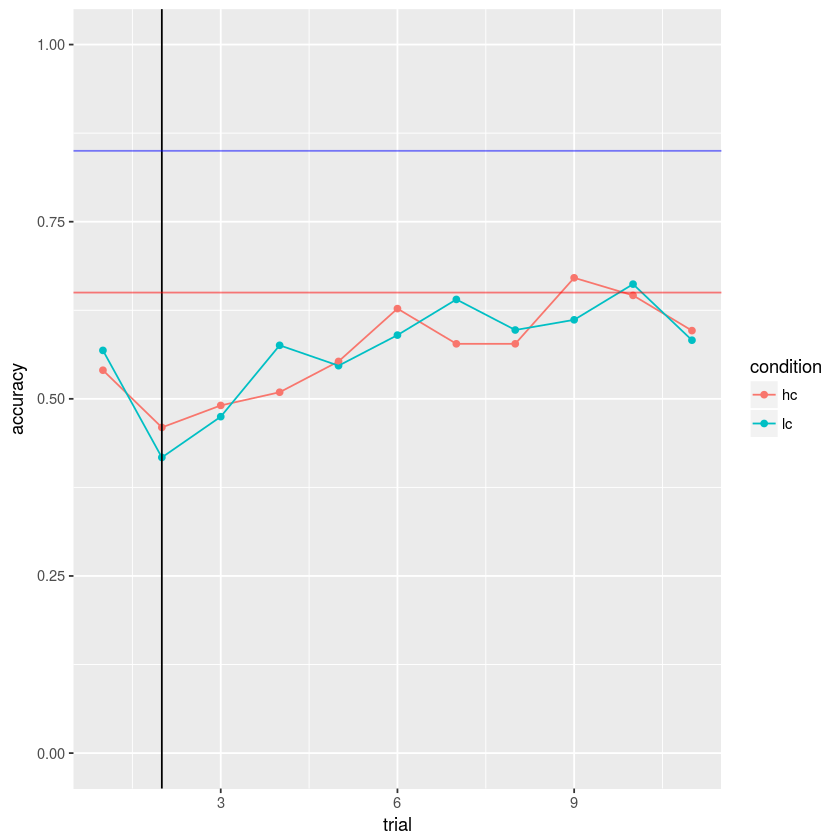

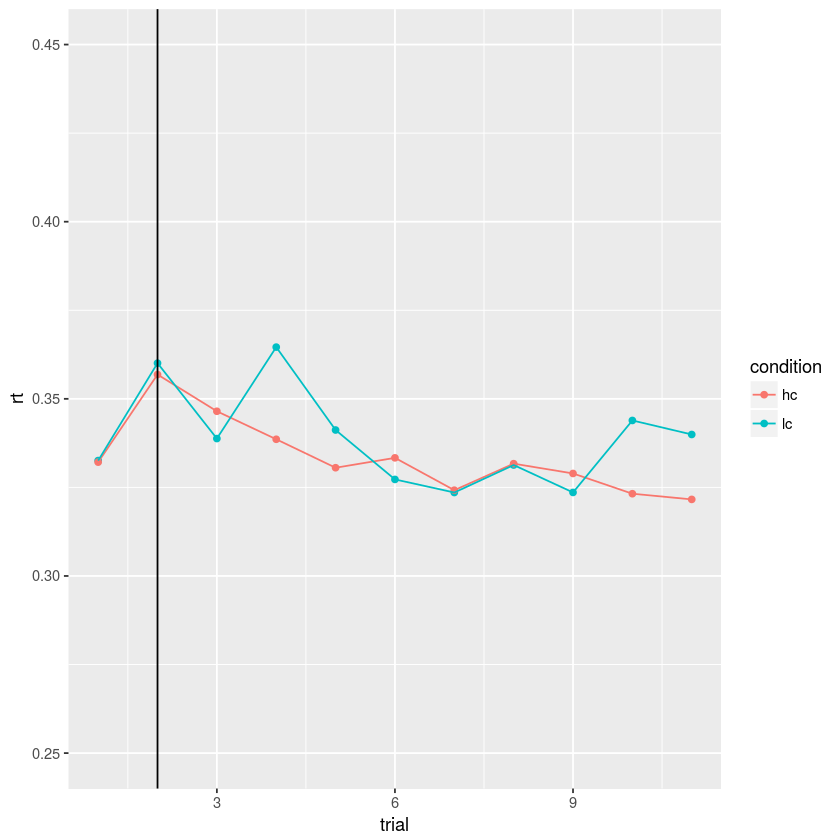

In [59]:
 conflict_acc_plt;conflict_rt_plt

## Volatility time series

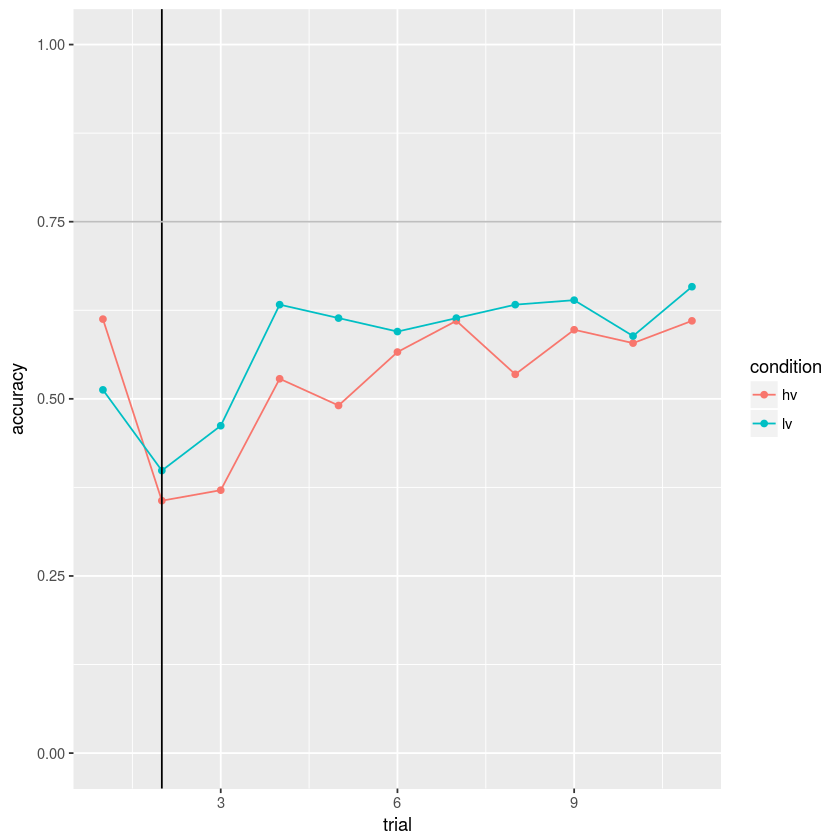

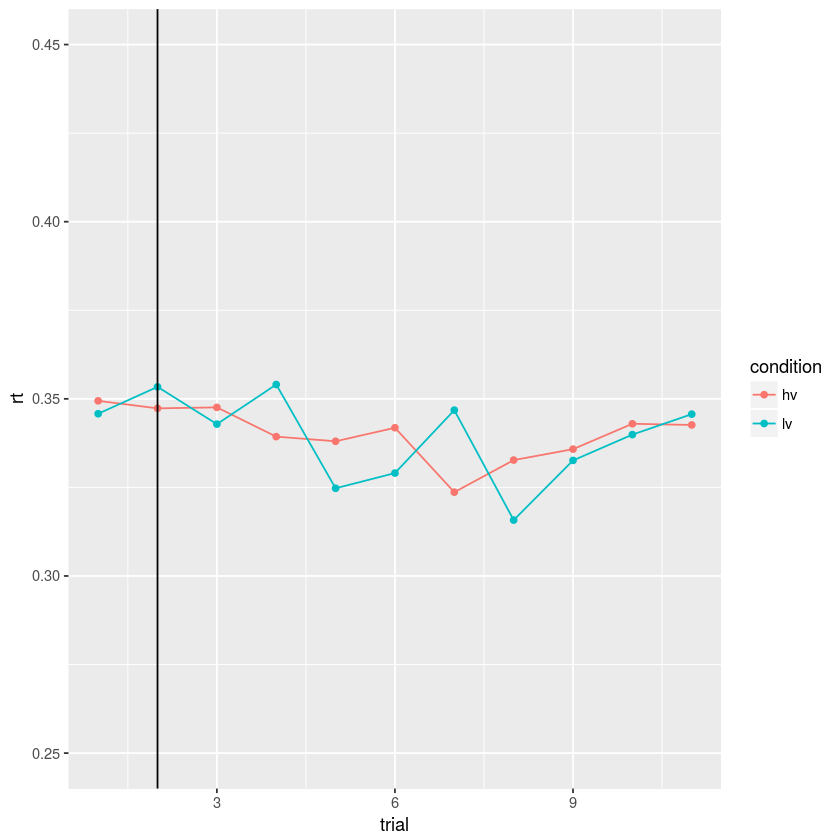

In [60]:
vol_acc_plt;vol_rt_plt

## Bootstrapped distributions of point estimates for behavior (mu accuracy, rt) 
### Note that this is currently over all trials. Need to bootstrap the average for each time point in the series that I'm plotting for nonparametric CIs.

In [61]:
setwd('/Users/Krista/Documents/R/functions')
source("bootstrap.R")

ERROR: Error in setwd("/Users/Krista/Documents/R/functions"): cannot change working directory


In [62]:
# would have been elegant but doesn't work as is
# condition_rt.boot <- sparse_df %>%  
#     group_by(condition)  %>% select(rt) %>% map(boot.mean)

In [63]:
hc_rt.boot <- boot.mean(sparse_df[which(sparse_df$condition=='hc'), 'rt'])
lc_rt.boot <- boot.mean(sparse_df[which(sparse_df$condition=='lc'), 'rt'])

hv_rt.boot <- boot.mean(sparse_df[which(sparse_df$condition=='hv'), 'rt'])
lv_rt.boot <- boot.mean(sparse_df[which(sparse_df$condition=='lv'), 'rt'])

ERROR: Error in boot.mean(sparse_df[which(sparse_df$condition == "hc"), "rt"]): could not find function "boot.mean"


In [ ]:
hc_acc.boot <- boot.mean(sparse_df[which(sparse_df$condition=='hc'), 'accuracy'])
lc_acc.boot <- boot.mean(sparse_df[which(sparse_df$condition=='lc'), 'accuracy'])

hv_acc.boot <- boot.mean(sparse_df[which(sparse_df$condition=='hv'), 'accuracy'])
lv_acc.boot <- boot.mean(sparse_df[which(sparse_df$condition=='lv'), 'accuracy'])

In [ ]:
hc_rt.boot$interval; lc_rt.boot$interval
hc_acc.boot$interval; lc_acc.boot$interval

In [ ]:
hv_rt.boot$interval; lv_rt.boot$interval
hv_acc.boot$interval; lv_acc.boot$interval

In [ ]:
#want to overlay bootstrapped distributions for counter conditions 
conflict_rt.boot <- data.frame(stack(c(hc_rt_boot = hc_rt.boot$boot.statistics, lc_rt_boot=lc_rt.boot$boot.statistics)))
colnames(conflict_rt.boot) = c('bootstrapped_rt', 'condition')
conflict_rt.boot$condition <- sub("^(hc).*", "hc", conflict_rt.boot$condition)
conflict_rt.boot$condition <- sub("^(lc).*", "lc", conflict_rt.boot$condition)

In [ ]:
conflict_acc.boot <- data.frame(stack(c(hc_acc_boot = hc_acc.boot$boot.statistics, lc_acc_boot=lc_acc.boot$boot.statistics)))
colnames(conflict_acc.boot) = c('bootstrapped_acc', 'condition')
conflict_acc.boot$condition <- sub("^(hc).*", "hc", conflict_acc.boot$condition)
conflict_acc.boot$condition <- sub("^(lc).*", "lc", conflict_acc.boot$condition)

In [ ]:
#volatility bootstrapping 
vol_rt.boot <- data.frame(stack(c(hv_rt_boot = hv_rt.boot$boot.statistics, lv_rt_boot=lv_rt.boot$boot.statistics)))
colnames(vol_rt.boot) = c('bootstrapped_rt', 'condition')
vol_rt.boot$condition <- sub("^(hv).*", "hv", vol_rt.boot$condition)
vol_rt.boot$condition <- sub("^(lv).*", "lv", vol_rt.boot$condition)

In [ ]:
vol_acc.boot <- data.frame(stack(c(hv_acc_boot = hv_acc.boot$boot.statistics, lv_acc_boot=lv_acc.boot$boot.statistics)))
colnames(vol_acc.boot) = c('bootstrapped_acc', 'condition')
vol_acc.boot$condition <- sub("^(hv).*", "hv", vol_acc.boot$condition)
vol_acc.boot$condition <- sub("^(lv).*", "lv", vol_acc.boot$condition)

In [ ]:
binwidth = diff(range(conflict_rt.boot$bootstrapped_rt))/30
ggplot(conflict_rt.boot, aes(x=bootstrapped_rt)) + 
       geom_histogram(aes(y=..density..),binwidth=binwidth) + geom_density(aes(color=condition, fill=condition), alpha=0.2) + labs(title='conflict rt')

In [ ]:
binwidth = diff(range(vol_rt.boot$bootstrapped_rt))/30
ggplot(vol_rt.boot, aes(x=bootstrapped_rt)) + 
       geom_histogram(aes(y=..density..),binwidth=binwidth) + geom_density(aes(color=condition, fill=condition), alpha=0.2) + labs(title='volatility rt')

In [ ]:
binwidth = diff(range(vol_acc.boot$bootstrapped_acc))/30
ggplot(vol_acc.boot, aes(x=bootstrapped_acc)) + 
       geom_histogram(aes(y=..density..),binwidth=binwidth) + geom_density(aes(color=condition, fill=condition), alpha=0.2) + labs(title='volatility accuracy')

In [ ]:
binwidth = diff(range(conflict_acc.boot$bootstrapped_acc))/30
ggplot(conflict_acc.boot, aes(x=bootstrapped_acc)) + 
       geom_histogram(aes(y=..density..),binwidth=binwidth) + geom_density(aes(color=condition, fill=condition), alpha=0.2) + labs(title='conflict accuracy')

## bootstrapping example

In [ ]:
library(Lock5Data)
data(CommuteAtlanta)

In [ ]:
str(CommuteAtlanta)

In [ ]:
#find sample mean first
(time.mean = with(CommuteAtlanta, mean(Time)))

In [ ]:
#finding se 
#sample with replacement to form a matrix with one row for each bootstrap sample 
#and one column for each sampled value, matching original n
n_bootstrap_samples = 1000
n_sampled_vals = nrow(CommuteAtlanta)
boot.samples = matrix(sample(CommuteAtlanta$Time, size = n_bootstrap_samples * n_sampled_vals, replace = TRUE),
n_bootstrap_samples, n_sampled_vals)

In [ ]:
#now take average of each row of boot samples 
boot.statistics = apply(boot.samples, 1, mean)

In [ ]:
#visualize bootstrapped distribution of means
ggplot(data.frame(meanTime = boot.statistics),aes(x=meanTime)) +
geom_histogram(binwidth=0.25,aes(y=..density..)) +
geom_density(color="red")

In [ ]:
#find se of bootstrapped mean (std of dist. of means)
(time.se = sd(boot.statistics))

In [ ]:
#calc. bootstrapped confidence interval 
me = ceiling(10 * 2 * time.se)/10
round(time.mean, 1) + c(-1, 1) * me